# Some simple demos of approaches to Bayesian inference with unknown errors

In [1]:
from collections import OrderedDict

In [2]:
from matplotlib import pyplot as plt

In [3]:
import numpy as np
from scipy import stats
from scipy.stats import invgamma, norm

In [4]:
import corner

In [5]:
import rxmc

Using database version X4-2024-12-31 located in: /home/beyerk/db/exfor/unpack_exfor-2024/X4-2024-12-31


In [6]:
def log_posterior_batch(y, y_model, sigma2, m_prior, b_prior, sigma2_prior):
    """
    Calculate the log posterior given parameters, considering fixed y_model.
    """
    # Log likelihood
    residuals = y - y_model
    log_likelihood = -0.5 * np.sum(residuals**2 / sigma2) - (len(y) / 2) * np.log(
        2 * np.pi * sigma2
    )

    # Assuming m_prior and b_prior are already incorporated during m and b updates
    # Log prior for sigma^2
    log_prior_sigma2 = invgamma.logpdf(sigma2, a=sigma2_prior[0], scale=sigma2_prior[1])

    return log_likelihood + log_prior_sigma2

In [7]:
def metropolis_hastings_batched(
    y,
    x,
    n_iterations=1000,
    burn_in=200,
    batch_size=10,
    m_prior=(0, 10),
    b_prior=(0, 10),
    sigma2_prior=(1, 1),
    proposal_std=(0.1, 0.1, 0.1),
):
    prop_m, prop_b, prop_log_sigma2 = proposal_std

    # Initialization
    m_current = np.random.normal(m_prior[0], np.sqrt(m_prior[1]))
    b_current = np.random.normal(b_prior[0], np.sqrt(b_prior[1]))
    sigma2_current = invgamma.rvs(a=sigma2_prior[0], scale=sigma2_prior[1])
    y_model = m_current * x + b_current

    # Storage for samples
    m_samples = []
    b_samples = []
    sigma2_samples = []
    accepted = 0
    for iteration in range(n_iterations):
        if iteration % (2 * batch_size) < batch_size:
            # Update m and b
            m_proposal = m_current + np.random.normal(0, prop_m)
            b_proposal = b_current + np.random.normal(0, prop_b)
            y_model_proposal = m_proposal * x + b_proposal

            # Calculate and compare log posterior
            current_log_post = log_posterior_batch(
                y, y_model, sigma2_current, m_prior, b_prior, sigma2_prior
            )
            proposed_log_post = log_posterior_batch(
                y, y_model_proposal, sigma2_current, m_prior, b_prior, sigma2_prior
            )

            acceptance_prob = np.exp(proposed_log_post - current_log_post)
            if np.random.rand() < acceptance_prob:
                m_current, b_current, y_model = m_proposal, b_proposal, y_model_proposal
                accepted += 1

        else:
            # Update sigma^2
            log_sigma2_proposal = np.log(sigma2_current) + np.random.normal(
                0, prop_log_sigma2
            )
            sigma2_proposal = np.exp(log_sigma2_proposal)

            # Calculate and compare log posterior (holding m and b fixed)
            current_log_post = log_posterior_batch(
                y, y_model, sigma2_current, m_prior, b_prior, sigma2_prior
            )
            proposed_log_post = log_posterior_batch(
                y, y_model, sigma2_proposal, m_prior, b_prior, sigma2_prior
            )

            acceptance_prob = np.exp(proposed_log_post - current_log_post)
            if np.random.rand() < acceptance_prob:
                sigma2_current = sigma2_proposal
                accepted += 1

        # Store samples after burn-in
        if iteration >= burn_in:
            m_samples.append(m_current)
            b_samples.append(b_current)
            sigma2_samples.append(sigma2_current)

    return m_samples, b_samples, sigma2_samples, accepted / (n_iterations - burn_in)

In [8]:
true_params = OrderedDict(
    [
        ("m", 2),
        ("b", 4),
    ]
)

In [9]:
rng = np.random.default_rng(13)

In [10]:
noise = 0.05
N = 20
x_data = np.linspace(0, 1, N)
y_true = true_params["m"] * x_data + true_params["b"]
y_err = np.array([rng.normal(0, noise * y) for y in y_true])
y_data = y_true + y_err

# Define priors: (mean, variance) for normal, (alpha, beta) for inverse gamma
reported_stat_err = noise * np.mean(y_data)
m_prior = (2, 10)
b_prior = (1, 10)
sigma2_prior = (3, reported_stat_err / (3 - 1))

# Run Metropolis-Hastings in batches
m_samples, b_samples, sigma2_samples, acc_frac = metropolis_hastings_batched(
    y_data,
    x_data,
    m_prior=m_prior,
    b_prior=b_prior,
    sigma2_prior=sigma2_prior,
    proposal_std=(0.1, 0.1, 0.1),
    n_iterations=30000,
)
print(f"Acceptance fraction {acc_frac}")
print(f"Estimated m: {np.mean(m_samples)} +/- {np.std(m_samples)}")
print(f"Estimated b: {np.mean(b_samples)} +/- {np.std(b_samples)}")
print(f"Estimated sigma: {np.sqrt(np.mean(sigma2_samples))}")

/tmp/ipykernel_30522/1236123084.py:60: RuntimeWarning: overflow encountered in exp
  acceptance_prob = np.exp(proposed_log_post - current_log_post)


Acceptance fraction 0.689261744966443
Estimated m: 1.9144201185260512 +/- 0.35117485815914995
Estimated b: 4.069394024636919 +/- 0.29639964078061537
Estimated sigma: 0.3157543258714706


In [11]:
class LinearModel(rxmc.physical_model.PhysicalModel):
    def __init__(self):
        params = [
            rxmc.params.Parameter("m", float, "no-units"),
            rxmc.params.Parameter("b", float, "y-units"),
        ]
        super().__init__(params)

    def evaluate(self, observation, m, b):
        return self.y(observation.x, m, b)

    def y(self, x, m, b):
        # useful to have a function hat takes in an array-like x
        # rather than an Observation, e.g. for plotting
        return m * x + b

In [12]:
prior_mean = OrderedDict(
    [
        ("m", 1),
        ("b", 5),
    ]
)
prior_std_dev = OrderedDict(
    [
        ("m", 0.5),
        ("b", 0.5),
    ]
)

In [13]:
covariance = np.diag(list(prior_std_dev.values())) ** 2
mean = np.array(list(prior_mean.values()))
prior_distribution = stats.multivariate_normal(mean, covariance)

In [14]:
my_model = LinearModel()

In [15]:
observation = rxmc.observation.Observation(
    x=x_data,
    y=y_data,
    y_stat_err=y_true * noise,
)

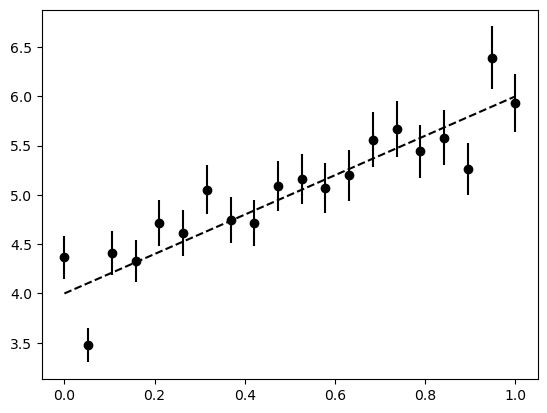

In [16]:
plt.errorbar(
    x_data,
    y_data,
    noise * y_data,
    color="k",
    marker="o",
    linestyle="none",
    label="experiment with bias",
)
plt.plot(x_data, y_true, "k--", label="truth")

In [17]:
likelihood = rxmc.likelihood_model.LikelihoodModel()
likelihood_unknown_stat = rxmc.likelihood_model.UnknownNoiseFractionErrorModel()

In [19]:
evidence = rxmc.evidence.Evidence(
    [
        rxmc.constraint.Constraint(
            [observation],
            my_model,
            likelihood,
        )
    ]
)
evidence_us = rxmc.evidence.Evidence(
    parametric_constraints=[
        rxmc.constraint.Constraint(
            [observation],
            my_model,
            likelihood_unknown_stat,
        )
    ]
)

In [20]:
noise_prior = stats.norm(loc=0.1, scale=0.5)

In [21]:
def proposal_distribution_noise(x):
    return np.atleast_1d(
        np.fabs(
            stats.multivariate_normal.rvs(
                mean=x, cov=np.array([[0.005]]), random_state=rng
            )
        )
    )

In [22]:
noise_sampling_config = rxmc.param_sampling.SamplingConfig(
    params=likelihood_unknown_stat.params,
    starting_location=np.array(noise_prior.mean()),
    proposal=proposal_distribution_noise,
    prior=noise_prior,
)

In [23]:
def proposal_distribution(x):
    return stats.multivariate_normal.rvs(
        mean=x, cov=prior_distribution.cov / 100, random_state=rng
    )

In [24]:
sampling_config = rxmc.param_sampling.SamplingConfig(
    params=my_model.params,
    starting_location=prior_distribution.mean,
    proposal=proposal_distribution,
    prior=prior_distribution,
)

In [25]:
walker = rxmc.walker.Walker(
    sampling_config,
    evidence_us,
    likelihood_sample_confs=[noise_sampling_config],
)

In [27]:
lm = walker.evidence.parametric_constraints[0].likelihood
o = walker.evidence.parametric_constraints[0].observations[0]

In [28]:
ym = y_true

In [29]:
noise_grid = np.linspace(0.01, 2, 1000)
logl = np.array([lm.log_likelihood(o, ym, eta) for eta in noise_grid])
chi2 = np.array([lm.chi2(o, ym, eta) for eta in noise_grid])
cov = [lm.covariance(o, ym, eta) for eta in noise_grid]
logdet = np.array([np.linalg.slogdet(c)[1] for c in cov])

In [30]:
mu = np.array(list(true_params.values()))

In [32]:
logl_w = [
    walker.evidence.log_likelihood(mu, [np.atleast_1d(eta)]) for eta in noise_grid
]

(0.0, 0.5)

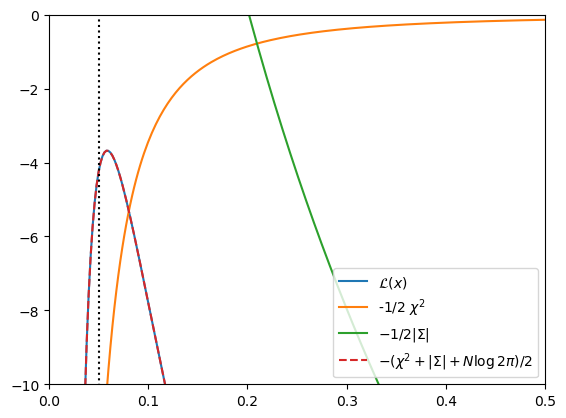

In [33]:
plt.plot(noise_grid, logl, label=r"$\mathcal{L}(x)$")
plt.plot(noise_grid, -0.5 * chi2, label=r"-1/2 $\chi^2$")
plt.plot(noise_grid, -0.5 * logdet, label=r"$-1/2 |\Sigma|$")
# plt.plot(noise_grid, logl_w, ":", label=r"w")

plt.plot(
    noise_grid,
    -0.5 * (logdet + chi2 + np.log(2 * np.pi) * N),
    "--",
    label=r"$-(\chi^2 + |\Sigma| + N\log{2\pi})/2$",
)
plt.vlines(noise, -300, 300, color="k", linestyles=[":"])
plt.legend(loc="lower right")
plt.ylim(-10, 0)
plt.xlim(0, 0.5)

In [34]:
%%time
walker.walk(n_steps=10000, burnin=1000, batch_size=100)

Burn-in batch 1/10 completed, 100 steps.
Burn-in batch 2/10 completed, 100 steps.
Burn-in batch 3/10 completed, 100 steps.
Burn-in batch 4/10 completed, 100 steps.
Burn-in batch 5/10 completed, 100 steps.
Burn-in batch 6/10 completed, 100 steps.
Burn-in batch 7/10 completed, 100 steps.
Burn-in batch 8/10 completed, 100 steps.
Burn-in batch 9/10 completed, 100 steps.
Burn-in batch 10/10 completed, 100 steps.
Batch: 1/100 completed, 100 steps. 
  Model parameter acceptance fraction: 0.740
  Likelihood parameter acceptance fractions: [0.22]
Batch: 2/100 completed, 100 steps. 
  Model parameter acceptance fraction: 0.750
  Likelihood parameter acceptance fractions: [0.2]
Batch: 3/100 completed, 100 steps. 
  Model parameter acceptance fraction: 0.770
  Likelihood parameter acceptance fractions: [0.25]
Batch: 4/100 completed, 100 steps. 
  Model parameter acceptance fraction: 0.680
  Likelihood parameter acceptance fractions: [0.3]
Batch: 5/100 completed, 100 steps. 
  Model parameter accep

(0.7436, [0.2203])

In [35]:
def plot_chains(walker, model, true_params):
    fig, axes = plt.subplots(
        walker.model_chain.shape[1] + 3, 1, figsize=(8, 8), sharex=True
    )
    for i in range(walker.model_chain.shape[1]):
        axes[i].plot(walker.model_chain[:, i])
        axes[i].set_ylabel(f"${model.params[i].latex_name}$ [{model.params[i].unit}]")
        true_value = true_params[model.params[i].name]
        axes[i].hlines(true_value, 0, len(walker.model_chain), "r", linestyle="--")

    axes[-3].plot(walker.log_posterior_record)
    axes[-3].set_ylabel(r"$\log{\mathcal{L}(\alpha_i | \mathcal{O})}$")

    lmp = walker.likelihood_sample_confs[0].params[0]
    axes[-2].plot(walker.likelihood_chain[0])
    axes[-2].set_ylabel(f"${lmp.latex_name}$ [{lmp.unit}]")
    axes[-2].hlines(noise, 0, len(walker.model_chain), "r", linestyle="--")

    axes[-1].plot(walker.log_posterior_record_lm[0])
    axes[-1].set_ylabel(r"$\log{\mathcal{L}(\alpha_i | \mathcal{O})}$")

    axes[-1].set_xlabel(r"$i$")
    # plt.legend(title="chains", ncol=3,)

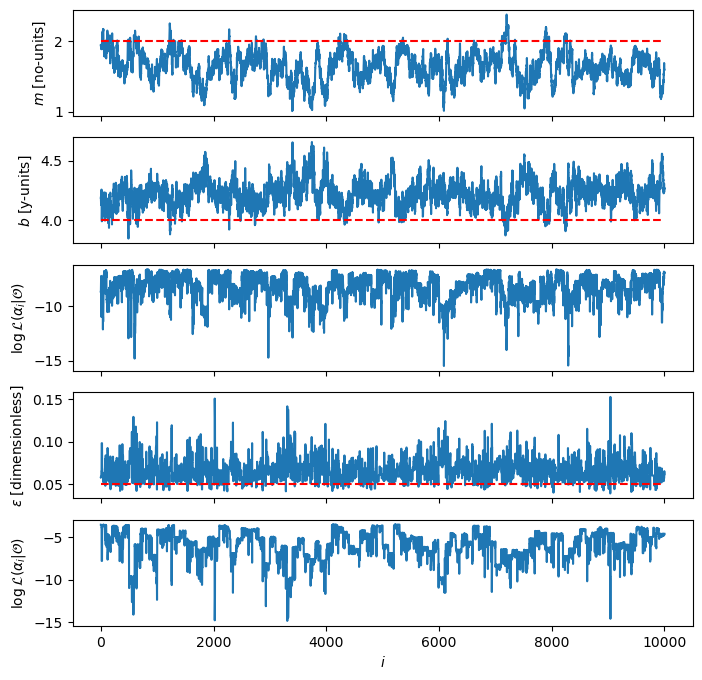

In [36]:
plot_chains(walker, my_model, true_params)

In [37]:
def plot_posterior_corner(walker):
    fig = corner.corner(
        np.hstack([walker.model_chain, walker.likelihood_chain[0]]),
        labels=[p.name for p in my_model.params]
        + [walker.likelihood_sample_confs[0].params[0].name],
        label="posterior",
        truths=[true_params["m"], true_params["b"], noise],
    )
    fig.suptitle("posterior")

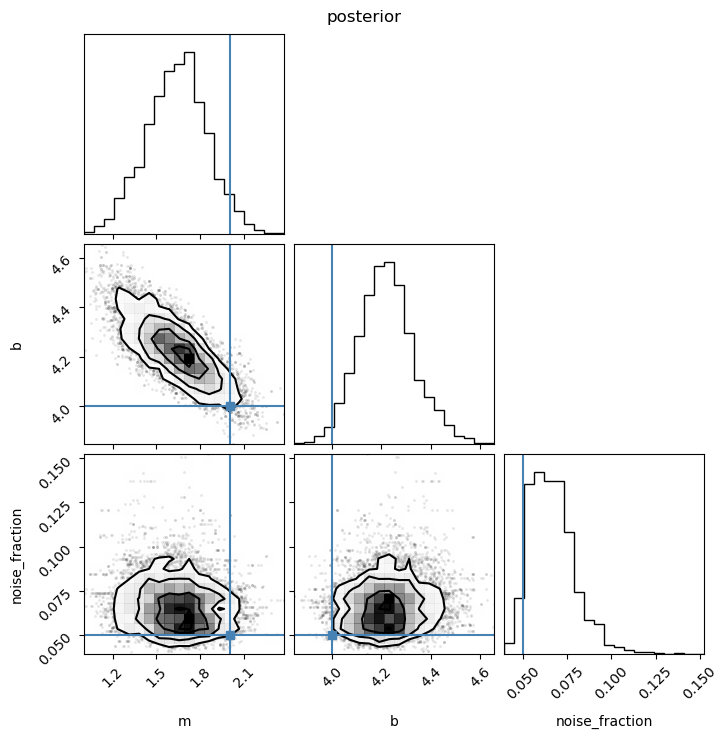

In [38]:
plot_posterior_corner(walker)

In [39]:
def plot_predictive_post(walker, model, x, y_exp, y_err, y_true):
    n_posterior_samples = walker.model_chain.shape[0]
    y = np.zeros((n_posterior_samples, len(x)))
    for i in range(n_posterior_samples):
        sample = walker.model_chain[i, :]
        y[i, :] = model.y(x, *sample)

    upper, lower = np.percentile(y, [5, 95], axis=0)
    plt.errorbar(
        x,
        y_exp,
        noise * y_data,
        color="k",
        marker="o",
        linestyle="none",
        label="experiment with bias",
    )

    plt.plot(x, y_true, "k--", label="truth")
    plt.fill_between(
        x,
        lower,
        upper,
        alpha=0.5,
        zorder=2,
        label=r"posterior inner 90$^\text{th}$ pctl",
    )
    return upper, lower

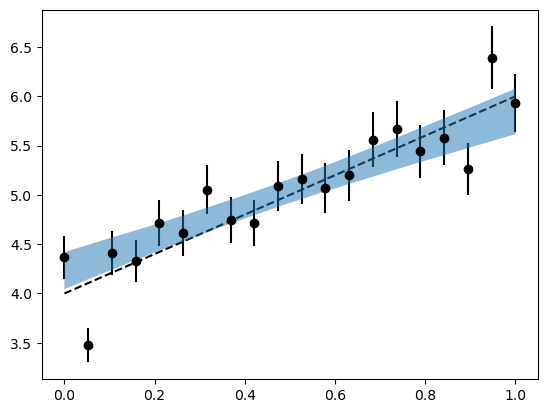

In [40]:
upper, lower = plot_predictive_post(walker, my_model, x_data, y_data, noise, y_true)